In [1]:
import json
import pandas as pd
from mplsoccer import Pitch, FontManager
import matplotlib.pyplot as plt
import os

# Load custom font for titles
font_manager = FontManager()

#Define the paths
matches_path = './open-data/data/matches/9/281.json'
events_dir = './open-data/data/events'

In [2]:
#load the match data and convert to dataframe
with open(matches_path, 'r') as f:
    matches = json.load(f)

matches_df = pd.json_normalize(matches)

player_matches = []
player_id = None

player_name = 'Florian Wirtz'

#loop thru to matches to see if Wirtz is there
for match_id in matches_df['match_id']:
    event_file_path = os.path.join(events_dir, f"{match_id}.json")
    
    if os.path.exists(event_file_path):
        with open(event_file_path, 'r') as f:
            events = json.load(f)
        
        events_df = pd.json_normalize(events)
        
        player_ids = events_df[['player.name', 'player.id']].drop_duplicates()
        player_id_df = player_ids[player_ids['player.name'] == player_name]
        
        if not player_id_df.empty:
            player_matches.append(match_id)
            player_id = player_id_df['player.id'].values[0]
            print(f"Found {player_name}'s player ID: {player_id} in match ID: {match_id}")
    else:
        print(f"No event data found for match ID {match_id}.")

Found Florian Wirtz's player ID: 40724.0 in match ID: 3895302
Found Florian Wirtz's player ID: 40724.0 in match ID: 3895292
Found Florian Wirtz's player ID: 40724.0 in match ID: 3895348
Found Florian Wirtz's player ID: 40724.0 in match ID: 3895286
Found Florian Wirtz's player ID: 40724.0 in match ID: 3895220
Found Florian Wirtz's player ID: 40724.0 in match ID: 3895250
Found Florian Wirtz's player ID: 40724.0 in match ID: 3895266
Found Florian Wirtz's player ID: 40724.0 in match ID: 3895275
Found Florian Wirtz's player ID: 40724.0 in match ID: 3895180
Found Florian Wirtz's player ID: 40724.0 in match ID: 3895134
Found Florian Wirtz's player ID: 40724.0 in match ID: 3895121
Found Florian Wirtz's player ID: 40724.0 in match ID: 3895107
Found Florian Wirtz's player ID: 40724.0 in match ID: 3895074
Found Florian Wirtz's player ID: 40724.0 in match ID: 3895139
Found Florian Wirtz's player ID: 40724.0 in match ID: 3895086
Found Florian Wirtz's player ID: 40724.0 in match ID: 3895320
Found Fl

Goal 3:
  Location: [93.5, 40.1]
  xG: 0.042
  Minute: 67
  Second: 25
  Shot Type: Open Play
  Outcome: Goal
  Body Part: Right Foot
  Technique: Normal
Goal 4:
  Location: [103.6, 35.0]
  xG: 0.438
  Minute: 82
  Second: 29
  Shot Type: Open Play
  Outcome: Goal
  Body Part: Right Foot
  Technique: Normal
Goal 5:
  Location: [106.4, 48.8]
  xG: 0.290
  Minute: 89
  Second: 25
  Shot Type: Open Play
  Outcome: Goal
  Body Part: Right Foot
  Technique: Normal
Goal 7:
  Location: [108.0, 40.0]
  xG: 0.783
  Minute: 52
  Second: 15
  Shot Type: Penalty
  Outcome: Goal
  Body Part: Right Foot
  Technique: Normal
Goal 21:
  Location: [110.5, 35.0]
  xG: 0.171
  Minute: 85
  Second: 45
  Shot Type: Open Play
  Outcome: Goal
  Body Part: Right Foot
  Technique: Volley
Goal 22:
  Location: [104.0, 29.3]
  xG: 0.086
  Minute: 1
  Second: 25
  Shot Type: Open Play
  Outcome: Goal
  Body Part: Right Foot
  Technique: Normal
Goal 25:
  Location: [104.4, 30.2]
  xG: 0.329
  Minute: 56
  Second: 35

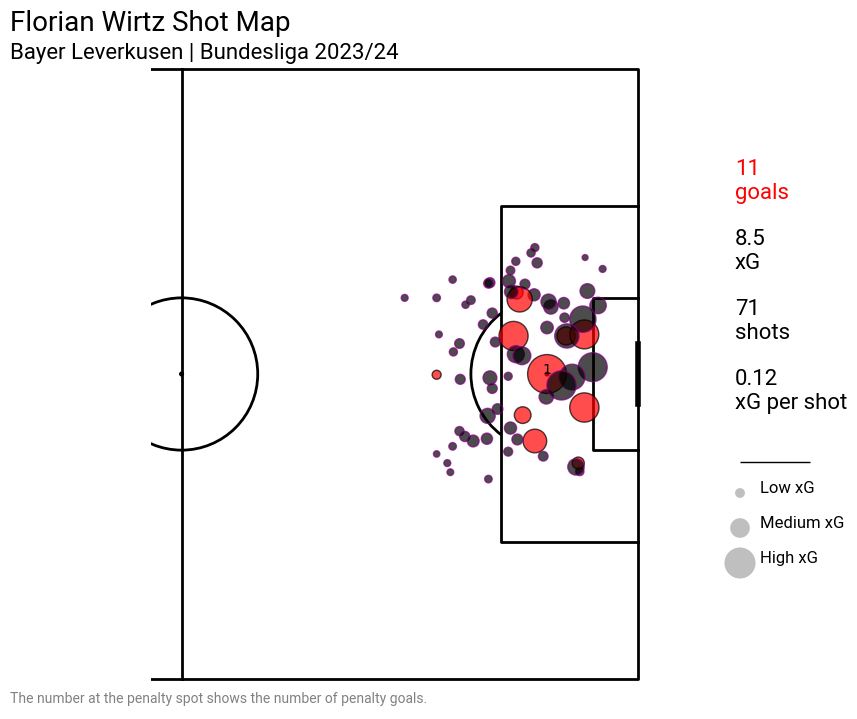

In [3]:
#filter for Wirtz shots in the matches and combine them into a dataframe
if player_matches:
    all_shots = []
    
    for match_id in player_matches:
        event_file_path = os.path.join(events_dir, f"{match_id}.json")
        
        if os.path.exists(event_file_path):
            with open(event_file_path, 'r') as f:
                events = json.load(f)
            
            events_df = pd.json_normalize(events)
            shots = events_df[(events_df['type.name'] == 'Shot') & (events_df['player.id'] == player_id)]
            
            if not shots.empty:
                all_shots.append(shots)
        else:
            print(f"No event data found for match ID {match_id}.")
            
    if all_shots:
        shots_df = pd.concat(all_shots, ignore_index=True)
        shots_df = shots_df.assign(
            x=shots_df['location'].apply(lambda loc: loc[0] if isinstance(loc, list) else None),
            y=shots_df['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)
        )

        #handle NaN values
        shots_df['goal'] = shots_df['shot.outcome.name'] == 'Goal'
        
        #set color based on goal or miss
        colors = shots_df['goal'].map({True: 'red', False: 'none'})  # Red for goals, clear for others
        edge_colors = shots_df['goal'].map({True: 'none', False: 'purple'})  # No edge for goals, purple for others

        #scale circle size based on xG
        shots_df['size'] = shots_df['shot.statsbomb_xg'] * 1000  # Adjust the scaling factor as needed

        #print data for each goal
        goals_df = shots_df[shots_df['goal']]
        for i, goal in goals_df.iterrows():
            print(f"Goal {i+1}:")
            print(f"  Location: {goal['location']}")
            print(f"  xG: {goal['shot.statsbomb_xg']:.3f}")
            print(f"  Minute: {goal['minute']}")
            print(f"  Second: {goal['second']}")
            print(f"  Shot Type: {goal['shot.type.name']}")
            print(f"  Outcome: {goal['shot.outcome.name']}")
            print(f"  Body Part: {goal['shot.body_part.name']}")
            print(f"  Technique: {goal['shot.technique.name']}")
            print("="*40)

        #half-pitch
        pitch = Pitch(line_color='black', pitch_type='statsbomb', half=True)
        fig, ax = pitch.draw(figsize=(10, 7))

        #plotshots with customized sizes and colors
        sc = pitch.scatter(shots_df['x'], shots_df['y'], s=shots_df['size'], c=colors, edgecolors=edge_colors, alpha=0.7, ax=ax)
        
        #count the number of penalty goals
        penalties = shots_df[(shots_df['shot.type.name'] == 'Penalty') & (shots_df['shot.outcome.name'] == 'Goal')]
        num_penalty_goals = len(penalties)

        #annotate the number at the penalty spot
        if num_penalty_goals > 0:
            pitch.annotate(str(num_penalty_goals), (penalties['x'].mean(), penalties['y'].mean()), fontsize=10, ha='center', ax=ax)

        #add summary statistics on the right side of the plot
        fig.text(0.825, 0.75, f'{shots_df["goal"].sum()}\ngoals', color='red', fontsize=16, fontproperties=font_manager.prop)
        fig.text(0.825, 0.65, f'{shots_df["shot.statsbomb_xg"].sum():.1f}\nxG', fontsize=16, fontproperties=font_manager.prop)
        fig.text(0.825, 0.55, f'{len(shots_df)}\nshots', fontsize=16, fontproperties=font_manager.prop)
        fig.text(0.825, 0.45, f'{shots_df["shot.statsbomb_xg"].mean():.2f}\nxG per shot', fontsize=16, fontproperties=font_manager.prop)

        #add a horizontal line to separate summary stats from xG legend
        ax.hlines(y=0.375, xmin=0.83, xmax=0.9, color='black', lw=1, transform=fig.transFigure, clip_on=False)

        size_labels = [0.05, 0.2, 0.5]  # Example xG values
        y_positions = [0.33, 0.28, 0.23]  # Adjust these to position the size legend properly

        for size, label, y_pos in zip(size_labels, ['Low xG', 'Medium xG', 'High xG'], y_positions):
            plt.scatter([0.83], [y_pos], s=size * 1000, c='gray', alpha=0.5, edgecolor='none', transform=fig.transFigure, clip_on=False)
            fig.text(0.85, y_pos, label, fontsize=12, fontproperties=font_manager.prop)
        
        #labels and titles
        fig.text(0.1, 0.99, f'{player_name} Shot Map', fontsize=20, fontproperties=font_manager.prop, ha='left')
        fig.text(0.1, 0.95, 'Bayer Leverkusen | Bundesliga 2023/24', fontsize=16, fontproperties=font_manager.prop, ha='left')
        fig.text(0.1, 0.03, 'The number at the penalty spot shows the number of penalty goals.', fontsize=10, color = 'grey', fontproperties=font_manager.prop)
        
        #save figure and display plot
        desktop_path = os.path.expanduser("~/Desktop/shot_map.png")
        plt.savefig(desktop_path, dpi=300, bbox_inches='tight', format='png')
        plt.show()
    else:
        print(f"No shot data found for {player_name}.")
else:
    print(f"{player_name} did not play in any of the processed matches.")

In [4]:
penalty_shots = shots_df[shots_df['shot.type.name'] == 'Penalty']
print("Penalty Shots:")
print(penalty_shots[['minute', 'second', 'shot.outcome.name', 'shot.statsbomb_xg']])
penalty_goals = penalty_shots[penalty_shots['shot.outcome.name'] == 'Goal']
print(f"Total Penalty Goals: {len(penalty_goals)}")
print("Penalty Goals Details:")
print(penalty_goals[['minute', 'second', 'shot.outcome.name', 'shot.statsbomb_xg']])

Penalty Shots:
   minute  second shot.outcome.name  shot.statsbomb_xg
6      52      15              Goal             0.7835
Total Penalty Goals: 1
Penalty Goals Details:
   minute  second shot.outcome.name  shot.statsbomb_xg
6      52      15              Goal             0.7835
